# Assigment 3 - Nguyen Thai Anh

Everything should be done ON MY code, no new code.


1. Read https://aclanthology.org/D14-1082.pdf and maybe just write one paragraph summary in your README.md in your github

2. Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)
Recall that we have 18 word + 18 pos + 12 dep features
Try to delete only the 12 dep features and check UAS
Try to delete only the 18 pos features and check UAS
3. Do another comparison study testing the embedding
Chaky uses some embedding
Try to use (1) glove embedding (smallest), (2) nn.Embedding (train from scratch) and compare with Chaky's embedding - on how it affects the UAS
4. Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency.

In [1]:
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm  #gimmick for progressbar when you train
import pickle #saving and loading models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

In [2]:
class Parsing(object):
    
    #init stack, buffer, dep
    def __init__(self, sentence):  
        self.sentence = sentence     #['The', 'cat', 'sat]  #conll format which is already in the tokenized form
        self.stack    = ['ROOT']
        self.buffer   = sentence[:]  #in the beginning, everything is inside the buffer
        self.dep      = []           #maintains a list of tuples of dep
    
    #parse function that tells me how shift, la, ra changes these three objects
    def parse_step(self, transition):     #transition could be either S, LA, RA
        if transition == 'S':
            #get the top guy in the buffer and put in stack
            head = self.buffer.pop(0)
            self.stack.append(head)
        elif transition == 'LA':  #stack = [ROOT, He, has] ==> append to dep (has, he) and then He is gone from the stack [ROOT, has]
            dependent = self.stack.pop(-2)  #He
            self.dep.append((self.stack[-1], dependent))  #(has, he)
        elif transition == 'RA':
            #can you guys try to this???
            dependent = self.stack.pop()  #stack = [ROOT, has, control] ==> dep (has, control), control will be gone fromt he stack [ROOT, has]
            self.dep.append((self.stack[-1], dependent))
        else:
            print(f"Bad transition: {transition}")
    
    #given some series of transition, it gonna for-loop the parse function
    def parse(self, transitions):
        for t in transitions:
            self.parse_step(t)
        return self.dep
    
    #check whether things are finished - no need to do anymore functions....
    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)  #so buffer is empty and ROOT is the only guy in stack

In [3]:
#create a instance of Parsing
parsing = Parsing(['He', 'has', 'good', 'control', '.'])

In [4]:
parsing.stack, parsing.buffer, parsing.dep

(['ROOT'], ['He', 'has', 'good', 'control', '.'], [])

In [5]:
#try to do a shift, and see what happen???
parsing.parse_step("S")
parsing.stack, parsing.buffer, parsing.dep

(['ROOT', 'He'], ['has', 'good', 'control', '.'], [])

In [6]:
#do shift, and then left arc
parsing.parse_step("S")
parsing.parse_step("LA")
parsing.stack, parsing.buffer, parsing.dep

(['ROOT', 'has'], ['good', 'control', '.'], [('has', 'He')])

In [7]:
parsing = Parsing(['He', 'has', 'good', 'control', '.'])

#use the parse function, to tell it to do S, S, L, S, S, L, R
#double check whether we have three dep (has, he), (control, good), (has, control)
parsing = Parsing(["He", "has", "good", "control","."])
parsing.parse(["S","S", "LA", "S", "S", "LA", "RA"])
parsing.stack, parsing.buffer, parsing.dep

(['ROOT', 'has'],
 ['.'],
 [('has', 'He'), ('control', 'good'), ('has', 'control')])

### Minibatch parsing

In [8]:
def minibatch_parse(sentences, model, batch_size):
    dep = []  #all the resulting dep
    
    #init Parsing instance for each sentence in the batch
    partial_parses = [Parsing(sentence) for sentence in sentences]  #in tokenized form
    #Parsing(['The', 'cat', 'sat']), Parsing(['Chaky', 'is', 'mad'])
    
    unfinished_parses = partial_parses[:]
    
    #while we still have sentence
    while unfinished_parses:  #if there are still a Parsing object
    
        #take a certain batch of sentence
        minibatch = unfinished_parses[:batch_size] #number of Parsing object
        
        #create a dummy model to tell us what's the next transition for each sentence
        transitions = model.predict(minibatch) 
        #transitions = [S, S, .....]
        #minibatch   = [Parsing(sentence1), Parsing(sentence2)]
        
                
        # for transition predicted this dummy model
        for transition, partial_parse in zip(transitions, minibatch):
            #parse step
            #transition: S
            #partial_parse: Parsing(sentence)
            partial_parse.parse_step(transition)
            
        #remove any sentence is finish
        unfinished_parses[:] = [p for p in unfinished_parses if not p.is_completed()]
    
    dep = [parse.dep for parse in partial_parses]
    
    return dep

In [9]:
class DummyModel(object):
    def predict(self, partial_parses):
        #partial_parses: list of Parsing instances
        #first shift everything onto the stack, and then just do RA if the first word
        #of the sentence is "right", otherwise, is "left"
        return [("RA" if pp.stack[1] == "right" else "LA") if len(pp.buffer) == 0 else "S"
                for pp in partial_parses] 

### Testing the minibatch

In [10]:
sentences = [["right", "arcs", "only"],
             ["right", "arcs", "only", "again"],
             ["left", "arcs", "only"],
             ["left", "arcs", "only", "again"]]

minibatch_parse(sentences, DummyModel(), 2)

[[('arcs', 'only'), ('right', 'arcs'), ('ROOT', 'right')],
 [('only', 'again'), ('arcs', 'only'), ('right', 'arcs'), ('ROOT', 'right')],
 [('only', 'arcs'), ('only', 'left'), ('only', 'ROOT')],
 [('again', 'only'), ('again', 'arcs'), ('again', 'left'), ('again', 'ROOT')]]

## Load data

We used English Penn Treebank dataset in CoNLL format.

CoNLL is the conventional name for TSV formats in NLP (TSV - tab-separated values, i.e., CSV with as separator). It originates from a series of shared tasks organized at the Conferences of Natural Language Learning (hence the name)

In CoNLL formats,

every word (token) is represented in one line
every sentence is separated from the next by an empty line
every column represents one annotation
There are many formats, in our case, our conll file has 10 columns, the important columns are:

1: word
4: pos
6: head of the dependency
7: type of dependency

In [11]:
def read_conll(filename):
    
    examples = []
    
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i+1
            wa = line.strip().split('\t')  #['1', 'In', '_', 'ADP', 'IN', '_', '5', 'case', '_', '_']
            #In <--------  5th guy
            #     case
            
            if len(wa) == 10:  #if all the columns are there
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #the row is not exactly 10, it means new sentence
            elif len(word) > 0:  #if there is somethign inside the word
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level
                word, pos, head, dep = [], [], [], [] #clear word, pos, head, dep
        
        if len(word) > 0:  #if there is somethign inside the word
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level

    return examples

def load_data():
    print("1. Loading data")
    train_set = read_conll("./data/train.conll")
    dev_set   = read_conll("./data/dev.conll")
    test_set   = read_conll("./data/test.conll")
    
    #make my dataset smaller because my mac cannot handle it
    train_set = train_set[:1000]
    dev_set   = dev_set[:500]
    test_set  = test_set[:500]
    
    return train_set, dev_set, test_set

In [12]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [13]:
len(train_set), len(dev_set), len(test_set)

(1000, 500, 500)

In [14]:
#we eventually gonna make the dependency
#so maybe we can cheat a little bit, and see the answer

import spacy
from spacy import displacy #displacy is for visualization

nlp = spacy.load("en_core_web_sm")
doc = nlp("Ms. Haag plays Elianti .")
options = {"collapse_punct": False}

displacy.render(doc, options = options, style="dep", jupyter=True)

In [15]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1   #because we are not predicting the relations, we are only predicting S, L, R
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}  #use for easy coding
        self.id2tran = {i: t for (i, t) in enumerate(trans)}
        
        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        self.n_features = 18 + 18 + 12
        self.n_tokens = len(tok2id)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples
    
    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]
            
        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6
                
        features += p_features + d_features
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        
        return features

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):  #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Haag plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I cheated and take a look
            n_words = len(ex['word']) - 1  #excluding the root
            
            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):  #maximum times you can do either S, L, R
                
                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
                
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
                
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
                    
            else:
                all_instances += instances

        return all_instances
    
    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel  #left arc but you cannot do ROOT <--- He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel  #right arc because ROOT --> He
        labels += [1] if len(buf) > 0 else [0]  #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    
    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):
        
        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1
        
        #predict based on the last two words on the stack
        #stack: [ROOT, he, has]
        i0 = stack[-1] #has
        i1 = stack[-2] #he
        
        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]
        
        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0  #action is left arc ---> gold_t
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1  #right arc
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2  #shift
        
    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
            
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
        
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies

In [16]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [17]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

In [18]:
print("2. Building parser")
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
took 0.03 seconds


In [19]:
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']


In [20]:
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

In [21]:
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 35, 20, 0, 18, 21]


## Word Embedding

In [22]:
print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("./data/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.42 seconds


## Preprocessing

In [23]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.66 seconds


## Minibatch loader

In [24]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

## Neural Network

In [25]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=48,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

In [26]:
#just a class to get the average.....
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

## Training

In [28]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.43it/s]


Average Train Loss: 0.5286268933365742
Evaluating on dev set


125250it [00:00, 3859335.27it/s]       


- dev UAS: 57.29
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.69it/s]


Average Train Loss: 0.29002814677854377
Evaluating on dev set


125250it [00:00, 6638905.30it/s]       


- dev UAS: 64.86
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.19it/s]


Average Train Loss: 0.24226089194417
Evaluating on dev set


125250it [00:00, 6632786.33it/s]       


- dev UAS: 66.64
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.79it/s]


Average Train Loss: 0.206441817805171
Evaluating on dev set


125250it [00:00, 6508456.51it/s]       


- dev UAS: 67.91
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.93it/s]


Average Train Loss: 0.17962095762292543
Evaluating on dev set


125250it [00:00, 6486597.72it/s]       


- dev UAS: 70.35
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.65it/s]


Average Train Loss: 0.16318037267774343
Evaluating on dev set


125250it [00:00, 6554990.16it/s]       


- dev UAS: 72.59
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.92it/s]


Average Train Loss: 0.14549975749105215
Evaluating on dev set


125250it [00:00, 6661213.16it/s]       


- dev UAS: 73.73
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.73it/s]


Average Train Loss: 0.1338449101895094
Evaluating on dev set


125250it [00:00, 6319610.43it/s]       


- dev UAS: 73.81
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.10it/s]


Average Train Loss: 0.1192847560159862
Evaluating on dev set


125250it [00:00, 6582257.78it/s]       


- dev UAS: 75.17
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.97it/s]


Average Train Loss: 0.10812150221318007
Evaluating on dev set


125250it [00:00, 6498634.01it/s]       

- dev UAS: 75.08



## Testing

In [29]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6722759.25it/s]       

- test UAS: 75.77
Done!


## Assigment------

In [30]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Assigment3(object):

    def __init__(self, dataset, use_pos = True, use_dep = True):
        tok2id = dict() 
        #set pos and dep feature
        #### Dependency Features : If it is False, dependency relationship will prevent
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
            #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
            #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        self.use_pos = use_pos
        self.use_dep = use_dep
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1 #dependency relationship #because we ar not predicting the realtions, we are only predicting S, L, R
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)} #use for easy coding
        self.id2tran = {i: t for (i, t) in enumerate(trans)} 
        
        #### POS tag features : If it is False, POS tag will not be added as feature
            #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                    offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #### Word Features 
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        if self.use_pos :
            self.n_features = 18 + 18
        elif self.use_dep:
            self.n_features = 18 + 12 
        self.n_tokens = len(tok2id)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            head = [-1] + ex['head']
            if self.use_pos:
                pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id else self.P_UNK for w in ex['pos']]
                numer_examples.append({'word': word, 'pos': pos, 'head': head})
            if self.use_dep:
                dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id else -1 for w in ex['dep']]
                numer_examples.append({'word': word, 'head': head, 'dep': dep})
        return numer_examples

    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]

        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        if self.use_pos:
            #corresponding pos tags
            p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
            p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                if self.use_pos :
                    #corresponding pos
                    p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                    p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                    p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
                if self.use_dep:
                    #corresponding dep
                    d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                    d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                    d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                    d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                if self.use_pos:
                    p_features += [self.P_NULL] * 6
                if self.use_dep:
                    d_features += [self.D_NULL] * 6
        if self.use_pos:
            features += p_features
        elif self.use_dep:
            features += d_features
        assert len(features) == self.n_features 
        return features

    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):

        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1

        #predict based on the last two words on the stack
        #stack (ROOT, he, has)
        i0 = stack[-1] #has
        i1 = stack[-2] #he

        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        if self.use_dep:
            d0 = ex['dep'][i0]
            d1 = ex['dep'][i1]

        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples): #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Hang plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I chated and take a look
            n_words = len(ex['word']) - 1  #excluding the root

            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2): #during stack[0] buffer[1, 2, 3, 4, 5] #maximum times you can do either S, L, R

                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
               
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
            
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                all_instances += instances

        if not self.use_dep:
            all_instances = [[instance[0], instance[2]] for instance in all_instances] #return only 'word' and 'head'

        return all_instances

    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel #left arc but you cannot do ROOT <-----He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel #right arc because ROOT ----> He
        labels += [1] if len(buf) > 0 else [0] #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
                
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
                        
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
                
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                if self.use_pos:
                    for pred_h, gold_h, pos in \
                            zip(head[1:], ex['head'][1:], ex['pos'][1:]):
                            assert self.id2tok[pos].startswith(P_PREFIX)
                            pos_str = self.id2tok[pos][len(P_PREFIX):]
                            if (not self.punct(pos_str)):
                                UAS += 1 if pred_h == gold_h else 0
                                all_tokens += 1
                elif self.use_dep:
                    for pred_h, gold_h, gold_l in \
                            zip(head[1:], ex['head'][1:], ex['dep'][1:]):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies


In [31]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [32]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]
           
def minibatches(data, batch_size, use_dep = True):
    if use_dep == True :
        x = np.array([d[0] for d in data])
        y = np.array([d[2] for d in data])
        one_hot = np.zeros((y.size, 3))
        one_hot[np.arange(y.size), y] = 1
    else :
        x = np.array([d[0] for d in data])
        y = np.array([d[1] for d in data])
        one_hot = np.zeros((y.size, 3))
        one_hot[np.arange(y.size), y] = 1

    return get_minibatches([x, one_hot], batch_size)
    


In [33]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005, use_dep= True):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size, use_dep)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size, use_dep):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size,use_dep)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
    
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

## delete only the 18 pos features and check UAS
We have 18 word and 12 dep

In [34]:
train_set, dev_set, test_set = load_data()
print('2. Building parser....')
start = time.time()
parser = Assigment3(train_set,use_pos = False)
print("took {:.2f} seconds".format(time.time()-start))

1. Loading data
2. Building parser....
took 0.03 seconds


In [35]:
train_set = parser.numericalize(train_set)
dev_set = parser.numericalize(dev_set)
test_set = parser.numericalize(test_set)

In [36]:
print("4. Loading pretrained embeddings...",)
# config = Config()
start = time.time()
word_vectors = {}
for line in open('./data/en-cw.txt').readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.61 seconds
5. Preprocessing training data...
took 1.52 seconds


In [37]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features = 30) ## 18+12
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path, batch_size=1024, n_epochs=10, lr=0.0005, use_dep = True)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 35.56it/s]


Average Train Loss: 0.6501132287085056
Evaluating on dev set


125250it [00:00, 12174659.93it/s]      


- dev UAS: 46.25
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.35it/s]


Average Train Loss: 0.3537751038869222
Evaluating on dev set


125250it [00:00, 19390122.02it/s]      


- dev UAS: 52.59
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.92it/s]


Average Train Loss: 0.2830354804173112
Evaluating on dev set


125250it [00:00, 17820100.95it/s]      


- dev UAS: 54.61
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.86it/s]


Average Train Loss: 0.24737797708561024
Evaluating on dev set


125250it [00:00, 18968643.29it/s]      


- dev UAS: 57.89
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 36.42it/s]


Average Train Loss: 0.21548538003116846
Evaluating on dev set


125250it [00:00, 13834476.50it/s]      


- dev UAS: 57.34

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 35.60it/s]


Average Train Loss: 0.192329332853357
Evaluating on dev set


125250it [00:00, 19375818.83it/s]      


- dev UAS: 59.50
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 38.69it/s]


Average Train Loss: 0.17366518980513015
Evaluating on dev set


125250it [00:00, 18600593.99it/s]      


- dev UAS: 59.79
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.17it/s]


Average Train Loss: 0.162710747991999
Evaluating on dev set


125250it [00:00, 19116355.88it/s]      


- dev UAS: 60.88
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 38.47it/s]


Average Train Loss: 0.14548355216781297
Evaluating on dev set


125250it [00:00, 18989212.94it/s]      


- dev UAS: 62.53
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 37.40it/s]


Average Train Loss: 0.13372046376268068
Evaluating on dev set


125250it [00:00, 17708969.36it/s]      

- dev UAS: 61.98



In [38]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 12675205.71it/s]      

- test UAS: 63.84
Done!


## Try to delete only the 12 dep features and check UAS
We have 18 word and 18 pos

In [39]:
train_set, dev_set, test_set = load_data()
# len(train_set), len(dev_set), len(test_set)
print('2. Building parser....')
start = time.time()
parser = Assigment3(train_set, use_dep=False)
print("took {:.2f} seconds".format(time.time()-start))

1. Loading data
2. Building parser....
took 0.03 seconds


In [40]:
train_set = parser.numericalize(train_set)
dev_set = parser.numericalize(dev_set)
test_set = parser.numericalize(test_set)

In [41]:
print("4. Loading pretrained embeddings...",)
# config = Config()
start = time.time()
word_vectors = {}
for line in open('./data/en-cw.txt').readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 2.77 seconds
5. Preprocessing training data...
took 1.60 seconds


In [42]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features = 36) ## 18 + 18
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path, batch_size=1024, n_epochs=10, lr=0.0005, use_dep = False)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.10it/s]


Average Train Loss: 0.5066659351189932
Evaluating on dev set


125250it [00:00, 6847185.02it/s]       


- dev UAS: 60.42
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.45it/s]


Average Train Loss: 0.2672498617321253
Evaluating on dev set


125250it [00:00, 6990506.67it/s]       


- dev UAS: 68.49
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.77it/s]


Average Train Loss: 0.21198336717983088
Evaluating on dev set


125250it [00:00, 4779915.16it/s]       


- dev UAS: 71.54
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 31.85it/s]


Average Train Loss: 0.17859472365429005
Evaluating on dev set


125250it [00:00, 6696450.94it/s]       


- dev UAS: 73.10
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 31.79it/s]


Average Train Loss: 0.15063084103167057
Evaluating on dev set


125250it [00:00, 6380244.55it/s]       


- dev UAS: 73.53
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.97it/s]


Average Train Loss: 0.13452316401526332
Evaluating on dev set


125250it [00:00, 6817683.16it/s]       


- dev UAS: 74.88
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 32.41it/s]


Average Train Loss: 0.11842609662562609
Evaluating on dev set


125250it [00:00, 6642850.88it/s]       


- dev UAS: 73.95

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.00it/s]


Average Train Loss: 0.10467563895508647
Evaluating on dev set


125250it [00:00, 6356543.97it/s]       


- dev UAS: 76.47
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 30.22it/s]


Average Train Loss: 0.0915017540877064
Evaluating on dev set


125250it [00:00, 6697560.79it/s]       


- dev UAS: 76.91
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 30.62it/s]


Average Train Loss: 0.08202163549140096
Evaluating on dev set


125250it [00:00, 6852990.89it/s]       

- dev UAS: 76.90



In [43]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6985487.15it/s]       

- test UAS: 78.21
Done!


## 3. Do another comparison study testing the embedding

### Try to use (1) glove embedding (smallest)

In [46]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [47]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [48]:
glove_file = './glove.6B.50d.txt'
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [49]:
print("2. Building parser")
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
took 0.05 seconds


In [50]:
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

In [51]:
start = time.time()
train_examples = parser.create_instances(train_set)
print("For Create Instance \n took {:.2f} seconds".format(time.time() - start))

For Create Instance 
 took 1.81 seconds


In [52]:
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in model :
            embeddings_matrix[i] = model [token]
        elif token.lower() in model:
            embeddings_matrix[i] = model [token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

Embedding matrix shape (vocab, emb size):  (5157, 50)
took 1.85 seconds


In [53]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.99 seconds


In [54]:
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.57it/s]


Average Train Loss: 0.6335663441568613
Evaluating on dev set


125250it [00:00, 6541359.43it/s]       


- dev UAS: 53.55
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.64it/s]


Average Train Loss: 0.3404931941380103
Evaluating on dev set


125250it [00:00, 6397883.06it/s]       


- dev UAS: 60.42
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.56it/s]


Average Train Loss: 0.27888551478584606
Evaluating on dev set


125250it [00:00, 6610418.59it/s]       


- dev UAS: 63.01
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.42it/s]


Average Train Loss: 0.23965225741267204
Evaluating on dev set


125250it [00:00, 6319838.51it/s]       


- dev UAS: 64.62
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.96it/s]


Average Train Loss: 0.21395652430752912
Evaluating on dev set


125250it [00:00, 6621082.84it/s]       


- dev UAS: 65.49
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.28it/s]


Average Train Loss: 0.18992600372682014
Evaluating on dev set


125250it [00:00, 6654378.64it/s]       


- dev UAS: 68.00
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.99it/s]


Average Train Loss: 0.16915587801486254
Evaluating on dev set


125250it [00:00, 6569170.64it/s]       


- dev UAS: 69.94
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.87it/s]


Average Train Loss: 0.15160189693172774
Evaluating on dev set


125250it [00:00, 6643270.90it/s]       


- dev UAS: 69.07

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.55it/s]


Average Train Loss: 0.14334495132789016
Evaluating on dev set


125250it [00:00, 6582587.69it/s]       


- dev UAS: 70.09
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.65it/s]


Average Train Loss: 0.12534175238882503
Evaluating on dev set


125250it [00:00, 6574349.88it/s]       

- dev UAS: 70.78
New best dev UAS! Saving model.



In [55]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6760044.47it/s]       

- test UAS: 73.65
Done!


### nn.Embedding (train from scratch)

In [56]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [57]:
corpus_tokenized_train = [word['dep'] for word in train_set]
corpus_tokenized_train[1]

['compound', 'nsubj', 'root', 'dobj', 'punct']

In [58]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized_train)))

In [59]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [60]:
#adding unknown word
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

In [61]:
voc_size = len(vocabs)
voc_size

39

In [62]:
#use Counter to first count stuffs
from collections import Counter
#count the frequency of each word
#we somehow need this to claiclate the probability Pi
X_i = Counter(flatten(corpus_tokenized_train)) #merge all list ... (flattten is a function I defines)
# X_i['apple'] #get the probability of apple

In [63]:
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus_tokenized_train:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))
#since we have these occcurences, we can count, to make our co-occurence matrix!!!
X_ik_skipgram = Counter(skip_grams)

In [64]:
def weighting(w_i,w_j,X_ik): #we need w_i and w_j, because we can try its-co-occurrences, if it's too big, we scale it down
    #check whether the co-occurrences between these two word exits??
    try:
        x_ij = X_ik[(w_i,w_j)]
    except:
        x_ij = 1 #why one, so that the probability thingly won't break....
    
    #maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75

    #if the co-occurrences does not exceed x_max, cale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1 #this is the maximum probability you can havve
    
    return result

In [65]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} #for keeping the co-occurrences
weighting_dic = {} #for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs,2): #we need to also think its reverse
    # print(bigram)
    #if this bigram exists in X_ik_skipgrams
    #we gonna add this to our c-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram] #get the co-occurrences
        X_ik[bigram] = cooc + 1 #this is agian basically label smoothing.... (stability issue (especailly when divide something))
        X_ik[(bigram[1],bigram[0])] = cooc + 1 #trick to get all pairs
    else: #otherwise, do nothing
        pass
    #apply the weighting function using this co-occurrence matrix thingly
    weighting_dic[bigram] = weighting(bigram[0],bigram[1],X_ik)
    weighting_dic[(bigram[1],bigram[0])] = weighting(bigram[1],bigram[0],X_ik)

In [66]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    #loop through skipgram, and change it id because when sending model, it must number 
    skipg_grams_id = [(word2index[skip_gram[0]],word2index[skip_gram[1]]) for skip_gram in skip_grams]
    #randomly pick 'batch_size' indexes
    number_of_choices = len(skipg_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among  these random indexes
    
    # print(random_index)
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #xij (in batches)
    random_weighting = [] #f(xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skipg_grams_id[i][0]]) #same reason why I put bracket here....
        random_labels.append([skipg_grams_id[i][1]])

        #get coocs
        #first check whether it exists.....
        pair = skip_grams[i] #e.g., ['banana','fruit']
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing

        random_coocs.append([math.log(cooc)]) #1. why log, #2 why bracket -> size ==> (,1) #my neural network excepts (,1)
        
        #for weighting
        weighting = weighting_dic[pair] #why not user try... maybe it does not exist
        random_weighting.append(weighting)

    return np.array(random_inputs),np.array(random_labels),np.array(random_coocs),np.array(random_weighting)
        #return xi,xj
        #return cooc Xij
        #return weighting

In [67]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [68]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [70]:
import time
num_epochs = 5000
#for epoch
start_time = time.time()
for epoch in range(num_epochs):
    #get random batch
    input, label, cooc, weightin = random_batch(batch_size,corpus_tokenized_train,skip_grams,X_ik,weighting_dic)
    input_batch = torch.LongTensor(input)
    label_batch = torch.LongTensor(label)
    cooc_batch = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
    
    # print(input_batch.shape,label_batch.shape,cooc_batch.shape,weightin_batch.shape)

    #loss = model
    loss = model(input_batch,label_batch,cooc_batch,weightin_batch)
    #backpropagate
    loss.backward()

    #update alpha
    optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1} | Loss {loss:.6f} | Time : {epoch_mins}m {epoch_secs}s')

Epoch 1000 | Loss 386.531769 | Time : 0m 18s
Epoch 2000 | Loss 109.812561 | Time : 0m 35s
Epoch 3000 | Loss 112.132965 | Time : 0m 53s
Epoch 4000 | Loss 231.590515 | Time : 1m 10s
Epoch 5000 | Loss 138.392899 | Time : 1m 28s


In [71]:
torch.save(model.state_dict(), "model.pth")

In [72]:
model = model.load_state_dict(torch.load("model.pth"))

In [73]:
train_set, dev_set, test_set = load_data()
print('2. Building parser....')
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time()-start))

train_set = parser.numericalize(train_set)
dev_set = parser.numericalize(dev_set)
test_set = parser.numericalize(test_set)

1. Loading data
2. Building parser....
took 0.03 seconds


In [74]:
print("4. Loading pretrained embeddings...",)
# config = Config()
start = time.time()
# word_vectors = {}
# for line in open('./data/en-cw.txt').readlines():
#     we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
#     word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in model: #Changeing word_vector from en-cw.txt to model_scratch instead
            embeddings_matrix[i] = model[token]
        elif token.lower() in model:
            embeddings_matrix[i] = model[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 0.01 seconds
5. Preprocessing training data...
took 2.05 seconds


In [75]:
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 25.56it/s]


Average Train Loss: 0.6341386505713066
Evaluating on dev set


125250it [00:00, 6246199.11it/s]       


- dev UAS: 52.33
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 26.86it/s]


Average Train Loss: 0.3442261901994546
Evaluating on dev set


125250it [00:00, 6436449.55it/s]       


- dev UAS: 60.37
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.48it/s]


Average Train Loss: 0.2799704897527893
Evaluating on dev set


125250it [00:00, 6525028.58it/s]       


- dev UAS: 65.13
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 28.41it/s]


Average Train Loss: 0.24547126051038504
Evaluating on dev set


125250it [00:00, 6224662.02it/s]       


- dev UAS: 67.06
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.95it/s]


Average Train Loss: 0.21885712848355374
Evaluating on dev set


125250it [00:00, 6537370.75it/s]       


- dev UAS: 68.09
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.81it/s]


Average Train Loss: 0.1947268256917596
Evaluating on dev set


125250it [00:00, 6466636.01it/s]       


- dev UAS: 69.66
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 28.13it/s]


Average Train Loss: 0.1781847607344389
Evaluating on dev set


125250it [00:00, 6558590.94it/s]       


- dev UAS: 70.51
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 28.31it/s]


Average Train Loss: 0.16169419387976328
Evaluating on dev set


125250it [00:00, 5926363.61it/s]       


- dev UAS: 71.47
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 28.11it/s]


Average Train Loss: 0.14887732065593204
Evaluating on dev set


125250it [00:00, 6505393.86it/s]       


- dev UAS: 72.12
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 27.94it/s]


Average Train Loss: 0.13699670306717357
Evaluating on dev set


125250it [00:00, 4455138.58it/s]       

- dev UAS: 73.36
New best dev UAS! Saving model.



In [76]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6413582.91it/s]       

- test UAS: 74.82
Done!


##  Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency

In [77]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [78]:
test_sentence = [sent for sent in test_set if len(sent['word']) < 10]

In [79]:
# Let's handpick some sentences for our model
test_1 = test_sentence[1] 
test_2 = test_sentence[10] 

# To make it's the same format as we did above
test_model = list()
test_model.append(test_1)
test_model.append(test_2)


In [80]:
for sent in test_model:
    print(sent['word'])

['the', 'finger-pointing', 'has', 'already', 'begun', '.']
['just', 'thought', 'you', "'d", 'like', 'to', 'know', '.']


In [81]:
test_model = parser.numericalize(test_model)
for sent in test_model:
    print(sent['word'])

[5156, 85, 5154, 115, 566, 5154, 87]
[5156, 234, 1327, 162, 901, 287, 89, 904, 87]


In [82]:
# Prepare sentence for spacy
#Data of load_data()
test_spacy_sent1 = 'the finger-pointing has already already .'
test_spacy_sent2 = 'just thought you d like to know .'

#My data
test_spacy_sent3 = 'I love you so much'
test_spacy_sent4 = 'I will try to do homework NLP every day'

In [83]:
#we eventually gonna make the dependency
#so maybe we can cheat a little bit, and see the answer
test_spacy_sent = test_spacy_sent1,  test_spacy_sent2, test_spacy_sent3,  test_spacy_sent4 
import spacy
from spacy import displacy #displacy is for visualization
nlp = spacy.load("en_core_web_sm")
for sent in test_spacy_sent:
    doc = nlp(sent)
    options = {"collapse_punct": False}
    displacy.render(doc, options = options, style="dep", jupyter=True)

## Colusion

### 2  Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)
Recall that we have 18 word + 18 pos + 12 dep features \
Try to delete only the 12 dep features and check UAS\
Try to delete only the 18 pos features and check UAS

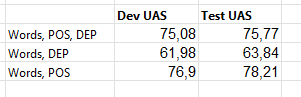

We will easily see that word + POS has the highest Dev UAS and test UAS while word + DEP has the lowest.\
From there, we see that POS has a great influence on the value of UAS .

### 3 Do another comparison study testing the embedding
Chaky uses some embedding\
Try to use (1) glove embedding (smallest), (2) nn.Embedding (train from scratch) and compare with Chaky's embedding - on how it affects the UAS

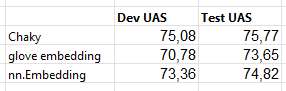

We will see that Chaky's test has the highest UAS compared to the other 2 tests.The models work well and the difference is not significant

### 4 Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency.


We will see that our neural network provides the same dependency however, there are also some mismatched words in the sentence.